In [1]:
import molpher
from molpher.core import MolpherMol

mol = MolpherMol("O=C(O)[C@H]1N(C(=O)[C@H](C)CS)CCC1")
print(mol.smiles)

CC(CS)C(=O)N1CCCC1C(=O)O


In [2]:
mol.smiles

'CC(CS)C(=O)N1CCCC1C(=O)O'

In [3]:
rd_mol = mol.asRDMol()
print(rd_mol)

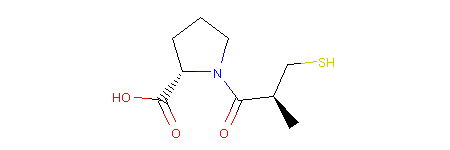

In [4]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = False

mol.asRDMol()

In [5]:
from molpher.random import set_random_seed
set_random_seed(42)

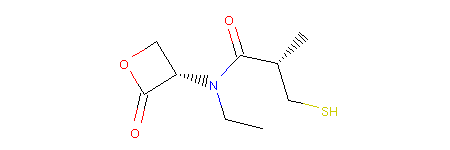

In [6]:
from molpher.core.morphing.operators import RerouteBond

rrbond = RerouteBond()
rrbond.setOriginal(mol)
morph = rrbond.morph()
morph.asRDMol()

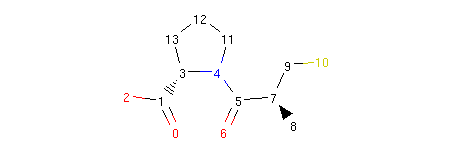

In [7]:
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
DrawingOptions.includeAtomNumbers=True

rrbond.getOriginal().asRDMol()

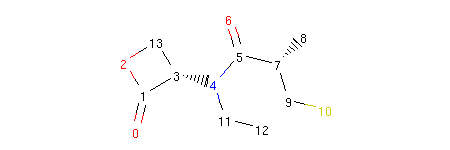

In [8]:
morph.asRDMol()

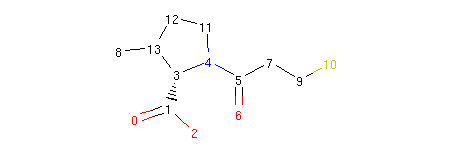

In [9]:
rrbond.morph().asRDMol()

In [10]:
from molpher.core.morphing import Molpher
from molpher.core.morphing.operators import AddAtom, RemoveAtom, MutateAtom

molpher = Molpher(
    mol
    , [
        AddAtom()
        , RemoveAtom()
        , MutateAtom()
    ]
    , attempts = 30
    , threads = 2
)

molpher()

morphs = molpher.morphs
print(len(morphs))
print(morphs[1:3])
print(molpher.morphs)

28
(<molpher.core.MolpherMol.MolpherMol at 0x7f0a0bc71fc0>, <molpher.core.MolpherMol.MolpherMol at 0x7f0a0b6e6f30>)
()


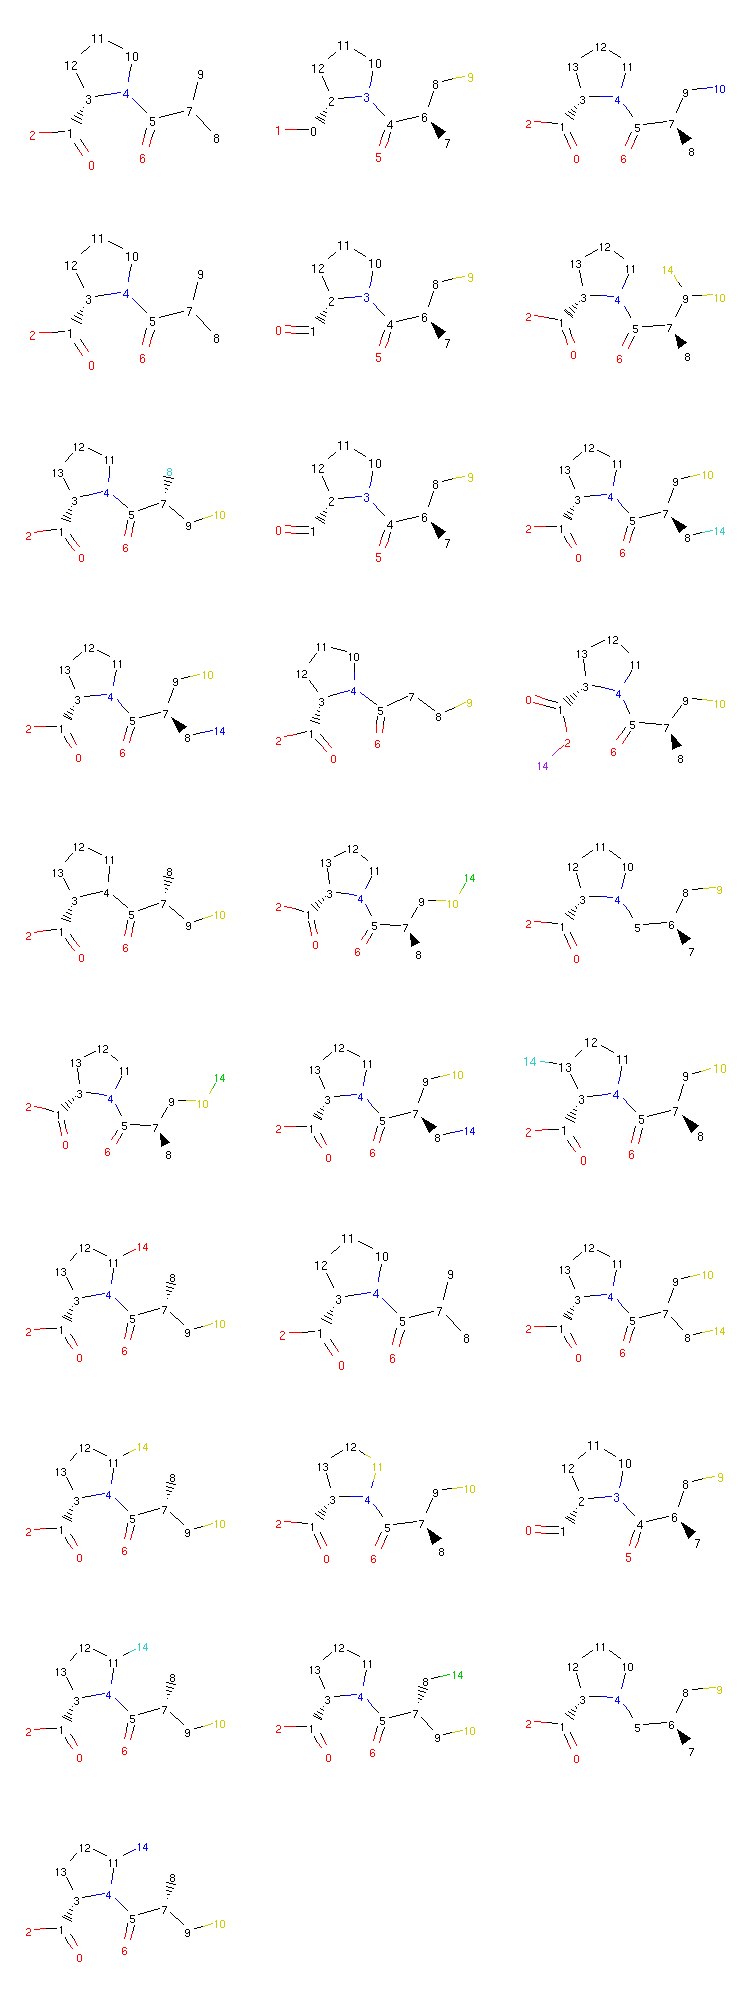

In [11]:
from rdkit.Chem.Draw import MolsToGridImage

def show_mol_grid(mols):
    return MolsToGridImage(
        [x.asRDMol() for x in mols]
        , subImgSize=(250,200)
    )

show_mol_grid(morphs)

90
46


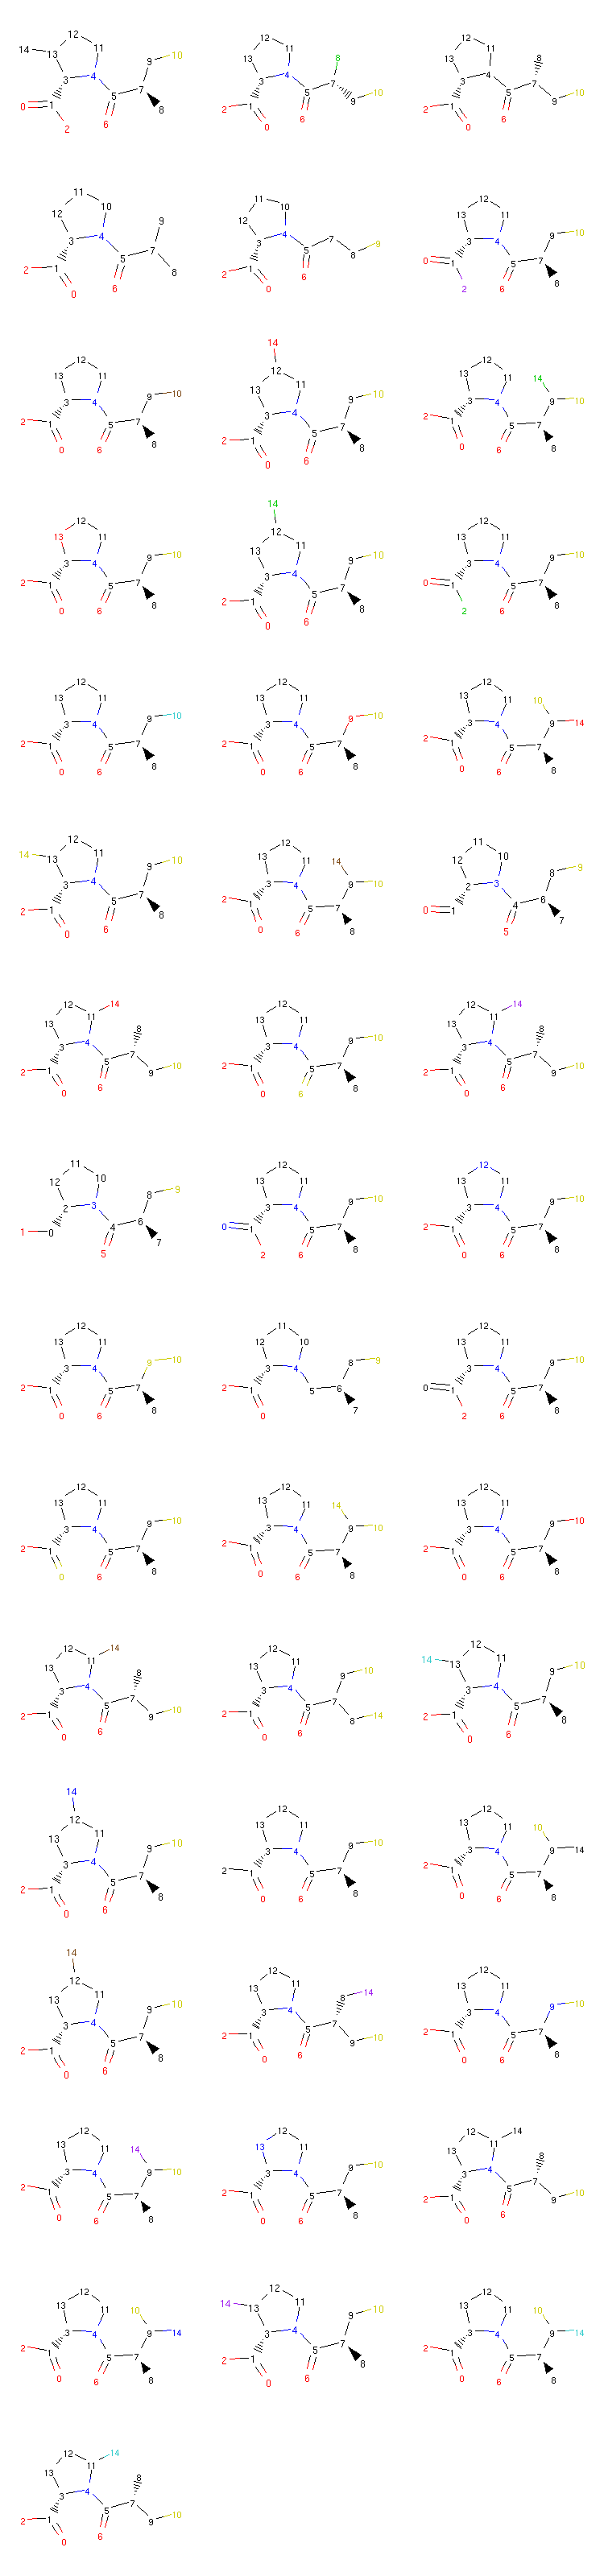

In [12]:
from rdkit import Chem

strange_patterns = Chem.MolFromSmarts('[S,O,N][F,Cl,Br,I]')
sensible_morphs = dict()
def collect_sensible(morph, operator):
    """
    a simple collector which identifies
    """
    
    rd_morph = morph.asRDMol()
    if not rd_morph.HasSubstructMatch(strange_patterns):
        sensible_morphs[morph.smiles] = morph

molpher = Molpher(
    mol
    , [
        AddAtom()
        , RemoveAtom()
        , MutateAtom()
    ]
    , attempts = 100
    , collectors = [collect_sensible]
)

molpher()

print(len(molpher.morphs))
print(len(sensible_morphs))
show_mol_grid(sensible_morphs.values())

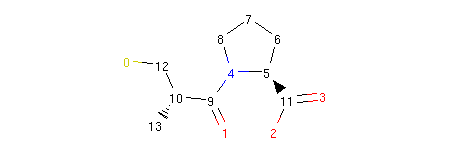

In [13]:
mol = MolpherMol("captopril.sdf")
mol.asRDMol()

In [14]:
for idx, atm in enumerate(mol.atoms):
    print(idx)
    print(atm.lock_info)

0
{'UNLOCKED': True, 'NO_MUTATION': False, 'NO_ADDITION': False, 'NO_REMOVAL': False, 'KEEP_NEIGHBORS': False, 'KEEP_NEIGHBORS_AND_BONDS': False, 'KEEP_BONDS': False, 'FULL_LOCK': False}
1
{'UNLOCKED': False, 'NO_MUTATION': True, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': True, 'KEEP_NEIGHBORS_AND_BONDS': True, 'KEEP_BONDS': True, 'FULL_LOCK': True}
2
{'UNLOCKED': False, 'NO_MUTATION': True, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': True, 'KEEP_NEIGHBORS_AND_BONDS': True, 'KEEP_BONDS': True, 'FULL_LOCK': True}
3
{'UNLOCKED': False, 'NO_MUTATION': True, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': True, 'KEEP_NEIGHBORS_AND_BONDS': True, 'KEEP_BONDS': True, 'FULL_LOCK': True}
4
{'UNLOCKED': False, 'NO_MUTATION': True, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': True, 'KEEP_NEIGHBORS_AND_BONDS': True, 'KEEP_BONDS': True, 'FULL_LOCK': True}
5
{'UNLOCKED': False, 'NO_MUTATION': True, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP

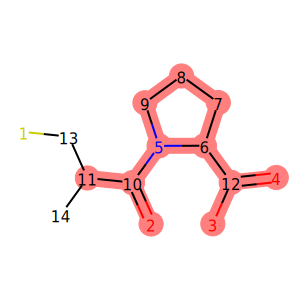

In [15]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def get_locked_ids(mol):
    return [idx for idx, atm in enumerate(mol.atoms) if atm.is_locked]

def show_locked_atoms(mol):
    rd_mol = mol.asRDMol()
    
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    
    # include atom indices
    opts = drawer.drawOptions()
    for i in range(rd_mol.GetNumAtoms()):
        opts.atomLabels[i] = str(i+1)
    
    # draw the molecule as SVG
    drawer.DrawMolecule(
        rd_mol
        , highlightAtoms=get_locked_ids(mol)
    )
    drawer.FinishDrawing()
    return SVG(drawer.GetDrawingText().replace('svg:',''))

show_locked_atoms(mol)

In [16]:
from molpher.core import MolpherAtom

mol.atoms[10].locking_mask == (MolpherAtom.NO_REMOVAL | MolpherAtom.NO_MUTATION)

True

In [17]:
mol.atoms[10].locking_mask = MolpherAtom.NO_REMOVAL
mol.atoms[10].lock_info

{'UNLOCKED': False,
 'NO_MUTATION': False,
 'NO_ADDITION': False,
 'NO_REMOVAL': True,
 'KEEP_NEIGHBORS': False,
 'KEEP_NEIGHBORS_AND_BONDS': False,
 'KEEP_BONDS': False,
 'FULL_LOCK': False}

80
26


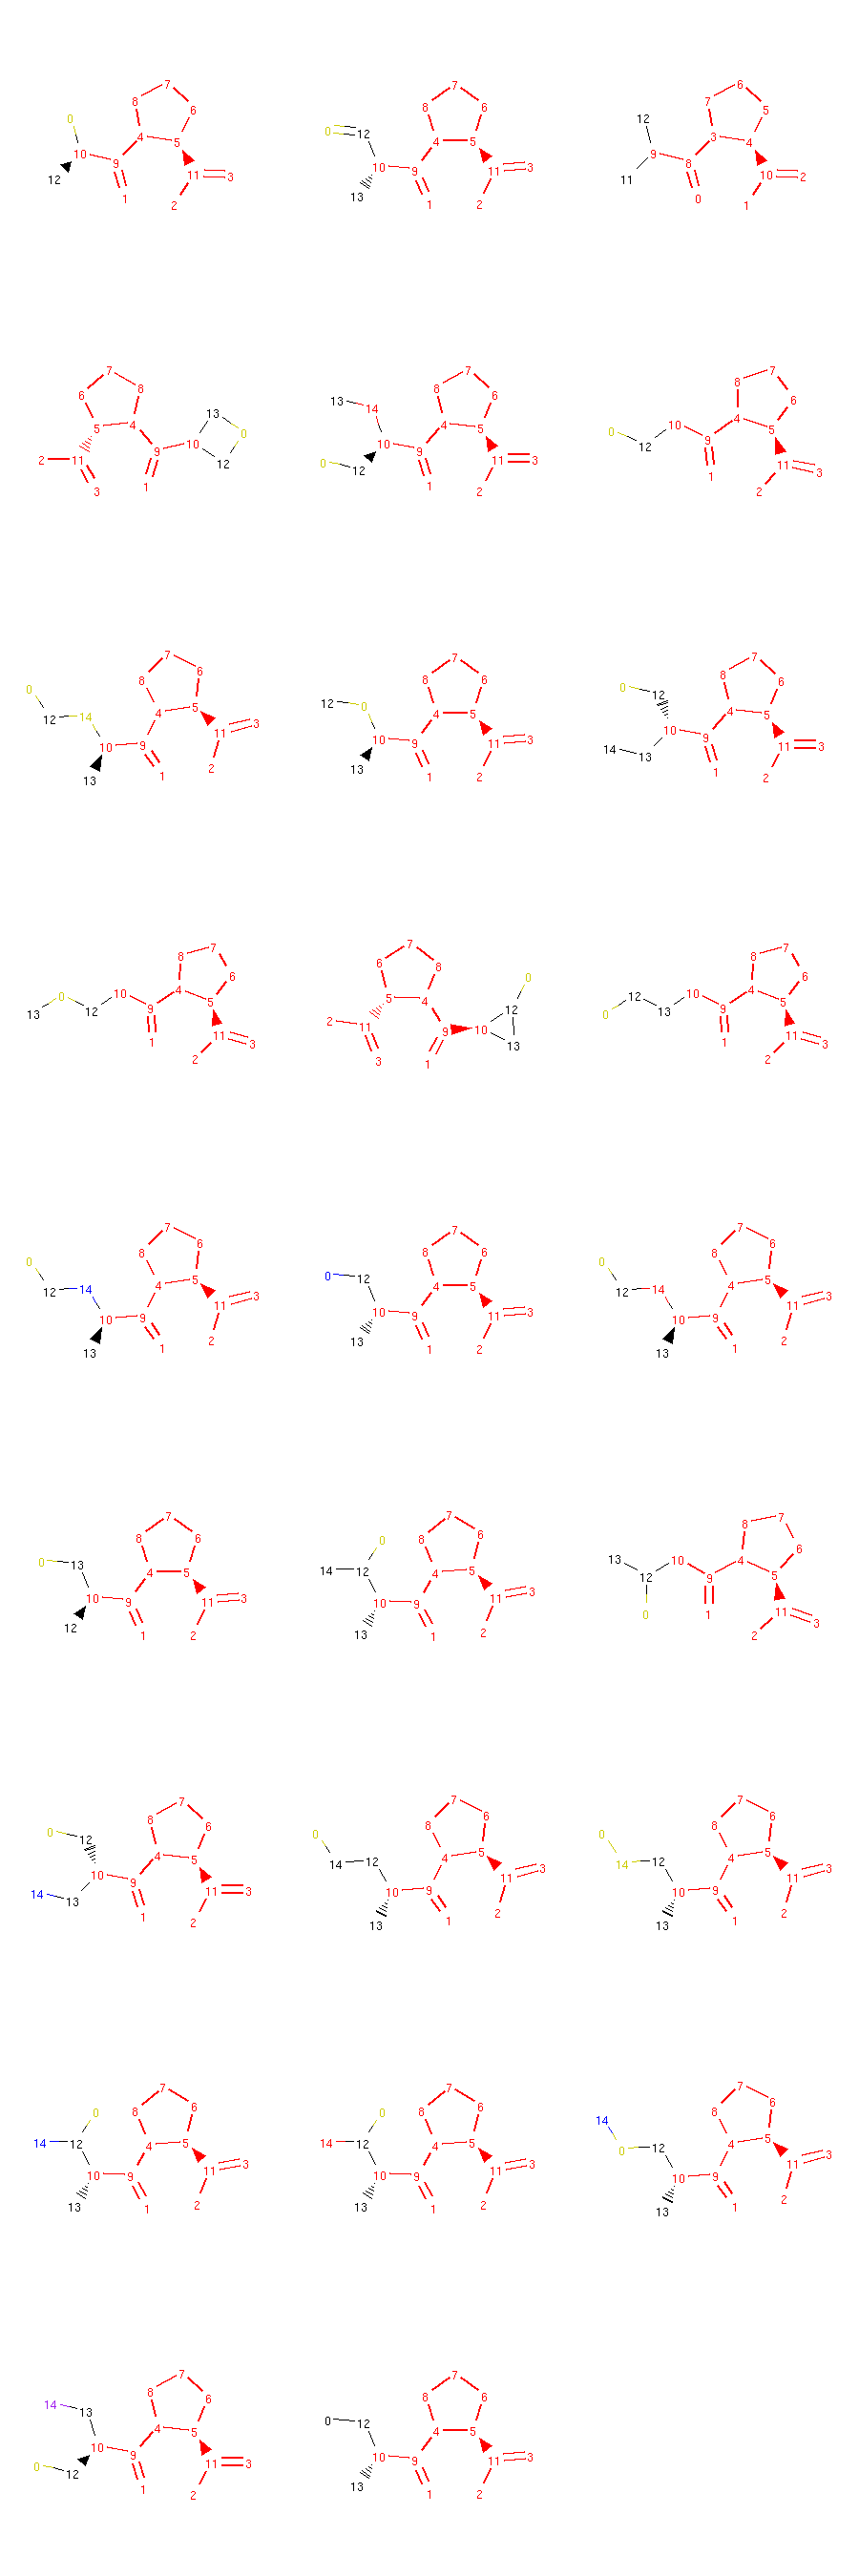

In [18]:
from rdkit import Chem
from molpher.core.morphing.operators import *

# new grid drawing code, will show atom locks
def show_mol_grid(mols):
    locked_atoms = [get_locked_ids(x) for x in mols]
    return MolsToGridImage(
        [x.asRDMol() for x in mols]
        , subImgSize=(300,300)
        , highlightAtomLists=locked_atoms
    )

# same as before
strange_patterns = Chem.MolFromSmarts('[S,O,N][F,Cl,Br,I]')
sensible_morphs = dict()
def collect_sensible(morph, operator):
    """
    a simple collector which identifies
    """
    
    rd_morph = morph.asRDMol()
    if not rd_morph.HasSubstructMatch(strange_patterns):
        sensible_morphs[morph.smiles] = morph

# same as before, but with all operators
molpher = Molpher(
    mol
    , [
        AddAtom()
        , RemoveAtom()
        , MutateAtom()
        , AddBond()
        , RemoveBond()
        , ContractBond()
        , InterlayAtom()
        , RerouteBond()
    ]
    , attempts = 100
    , collectors = [collect_sensible]
)

molpher()

print(len(molpher.morphs))
print(len(sensible_morphs))
show_mol_grid(sensible_morphs.values())

In [19]:
malonic_acid = MolpherMol("OC(=O)CC(=O)O")
malonic_acid.lockAtoms("OC(=O)", MolpherAtom.NO_ADDITION | MolpherAtom.NO_MUTATION)

(0, 1, 2, 6, 4, 5)